IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


BASIC DATA STRUCTURE

In [4]:
print(df.shape)          # rows, columns
df.info()                # dtypes and nulls
df['Attrition'].value_counts()


(1470, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel     

No     1233
Yes     237
Name: Attrition, dtype: int64

MINIMAL CLEANING

In [5]:
drop_cols = ["EmployeeNumber","Over18","EmployeeCount","StandardHours"]
df = df.drop(drop_cols, axis=1)
df["Attrition"] = df["Attrition"].map({"Yes":1, "No":0})


One-hot encode categoricals

In [6]:
df = pd.get_dummies(df, drop_first=True)


SPLIT

In [7]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.50,         
        random_state=42,
        stratify=y)             # keeps class ratio


Standardize features

In [8]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


Defining the 3 models

In [9]:
models = {
    "Neural Net, 2x32 relu": MLPClassifier(
        hidden_layer_sizes=(32,32),
        activation="relu",
        solver="adam",
        max_iter=300,
        random_state=42),
    "KNN, k=5": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree, depth=5": DecisionTreeClassifier(max_depth=5, random_state=42)
}


Train,evaluate,predict

In [10]:
results  = []
reports  = {}

for name, model in models.items():
    use_scaled = (name.startswith("Neural") or name.startswith("KNN"))
    X_tr = X_train_s if use_scaled else X_train
    X_te = X_test_s  if use_scaled else X_test
    
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / cm.sum()          # custom accuracy
    
    results.append([name, tp, tn, cm.sum(), round(acc*100,2)])
    reports[name] = classification_report(
                        y_test, y_pred,
                        target_names=["Stay","Leave"],
                        zero_division=0)

results_df = pd.DataFrame(
    results,
    columns=["Model","True Positives","True Negatives",
             "Total test cases","Accuracy percent"])
results_df


,Model,True Positives,True Negatives,Total test cases,Accuracy percent
0,"Neural Net, 2x32 relu",44,567,735,83.13
1,"KNN, k=5",20,600,735,84.35
2,"Decision Tree, depth=5",39,570,735,82.86


Show confusion matrices

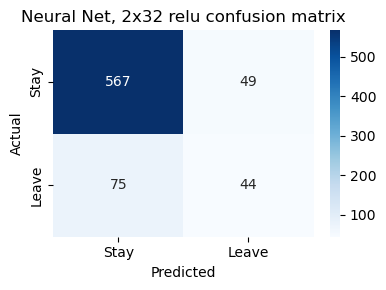

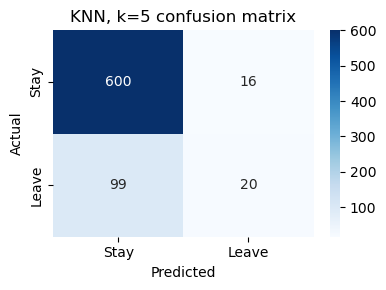

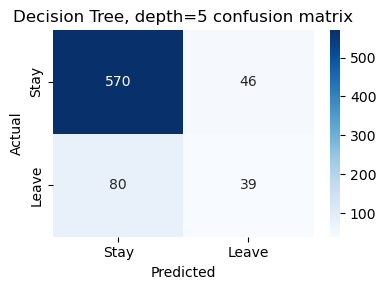

In [11]:
for name, model in models.items():
    use_scaled = (name.startswith("Neural") or name.startswith("KNN"))
    X_te = X_test_s if use_scaled else X_test
    y_pred = model.predict(X_te)

    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt="d", cmap="Blues",
                xticklabels=["Stay","Leave"],
                yticklabels=["Stay","Leave"])
    plt.title(f"{name} confusion matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


Visualize the tree

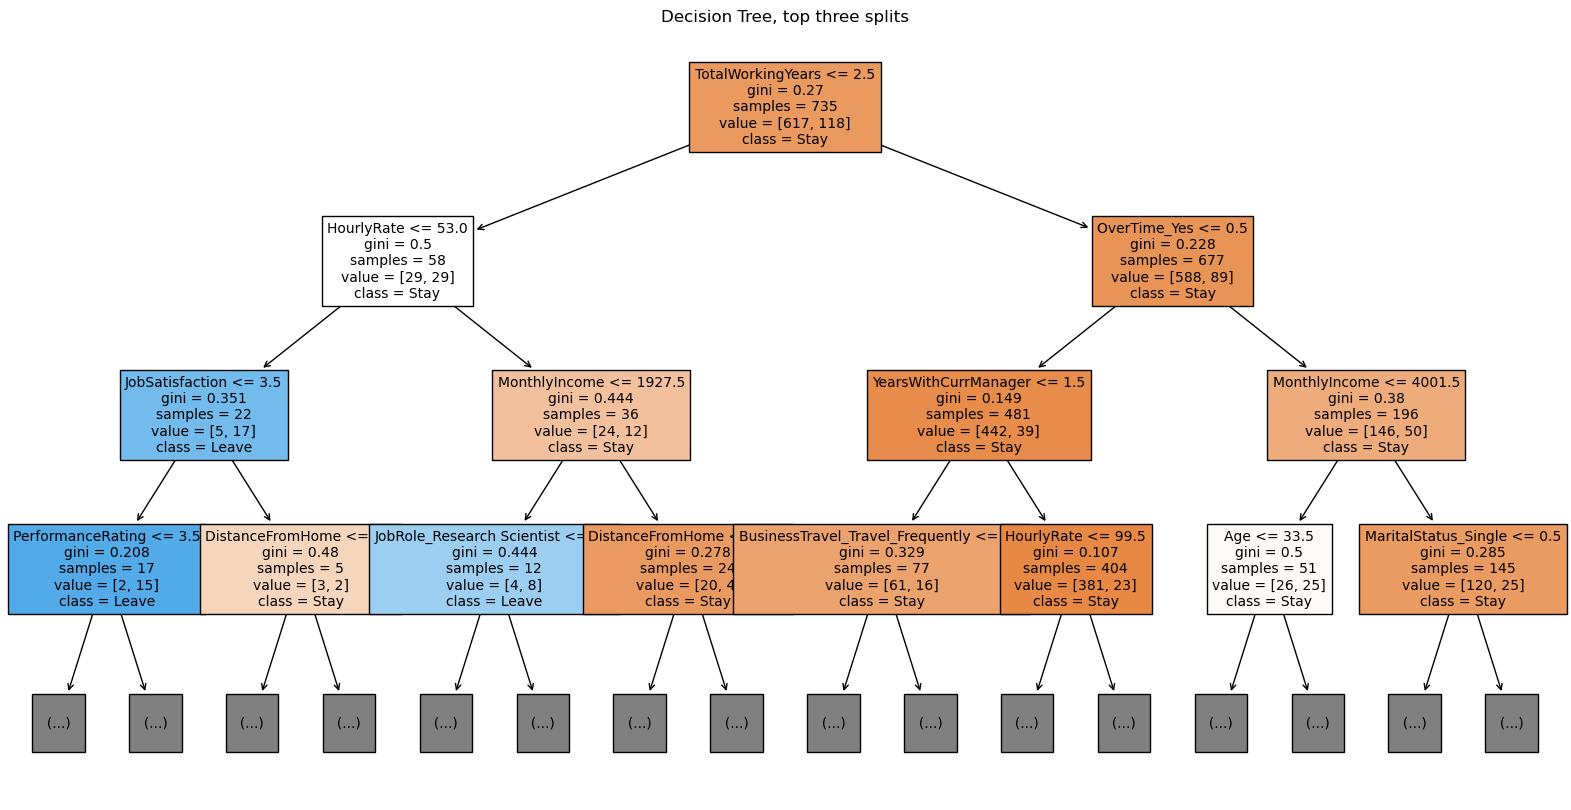

In [12]:
tree = models["Decision Tree, depth=5"]
plt.figure(figsize=(20,10))
plot_tree(tree,
          max_depth=3,           # first three levels only
          filled=True,
          feature_names=list(X.columns),
          class_names=["Stay","Leave"],
          fontsize=10)
plt.title("Decision Tree, top three splits")
plt.show()


Feature importance bar chart

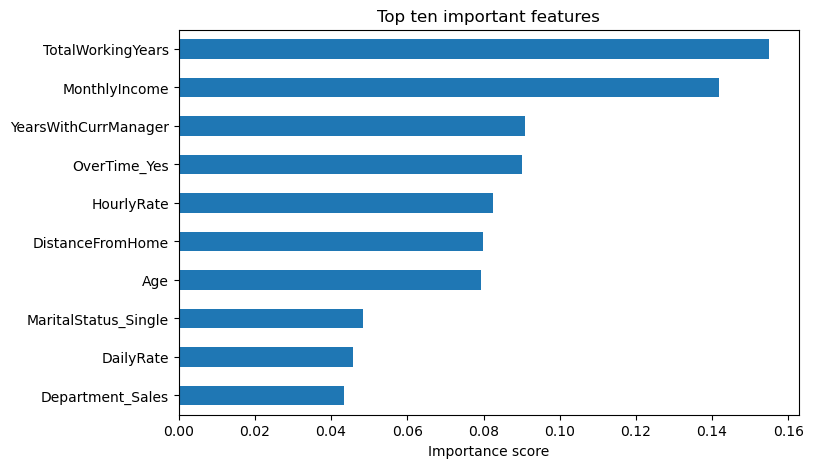

In [13]:
imp = pd.Series(tree.feature_importances_, index=X.columns)\
          .sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
imp.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top ten important features")
plt.xlabel("Importance score")
plt.show()
